In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn import metrics
import seaborn as sns
import pickle
import json

In [2]:
pred_list = []
proba_list = []

f1_list = []
auroc_list = []
pr_list = []
rc_list = []
acc_list = []

n_folds = 5
file_path = 'predictions/LSTM/Try1_5fold/'
y_test = np.load('../data/Haleh/y_test.npy')

avg_f1 = 0.0
avg_auroc = 0.0
avg_pr = 0.0
avg_rc = 0.0
avg_acc = 0.0

best_score = 0.0

for i in range(n_folds):
    pred_list.append(np.load(file_path + f'y_pred_fold_{i+1}.npy'))
    proba_list.append(np.load(file_path + f'y_proba_Fold_{i+1}.npy'))
    
    f1_list.append(metrics.f1_score(y_test, pred_list[i]))
    auroc_list.append(metrics.roc_auc_score(y_test, proba_list[i][:, 1]))
    pr_list.append(metrics.precision_score(y_test, pred_list[i]))
    rc_list.append(metrics.recall_score(y_test, pred_list[i]))
    acc_list.append(metrics.balanced_accuracy_score(y_test, pred_list[i]))
    
    avg_f1 += f1_list[i]
    avg_auroc += auroc_list[i]
    avg_pr += pr_list[i]
    avg_rc += rc_list[i]
    avg_acc += acc_list[i]
    
    if f1_list[i] > best_score:
        best_score = f1_list[i]
        best_y_pred = pred_list[i]
        best_y_proba = proba_list[i]
    
avg_f1 /= n_folds
avg_auroc /= n_folds
avg_pr /= n_folds
avg_rc /= n_folds
avg_acc /= n_folds
    

In [3]:
print('Balanced Acccuracy: \t{:.3f} ± {:.3f}'.format(avg_acc, np.std(acc_list)))
#print('Accuracy: \t\t{:.3f} ± {:.3f}'.format(acc))
print('AUROC: \t\t\t{:.3f} ± {:.3f}'.format(avg_auroc, np.std(auroc_list)))
print('F1:\t\t\t{:.3f} ± {:.3f}'.format(avg_f1, np.std(f1_list)))
print('Recall: \t\t{:.3f} ± {:.3f}'.format(avg_rc, np.std(rc_list)))
print('Precision: \t\t{:.3f} ± {:.3f}'.format(avg_pr, np.std(pr_list)))
#fig, ax = plt.subplots(1, 1, figsize=(15, 15))

Balanced Acccuracy: 	0.596 ± 0.007
AUROC: 			0.631 ± 0.005
F1:			0.284 ± 0.008
Recall: 		0.429 ± 0.038
Precision: 		0.214 ± 0.011


Balanced Acccuracy: 	0.605
Recall: 		0.411
Precision: 		0.233
F1: 			0.298


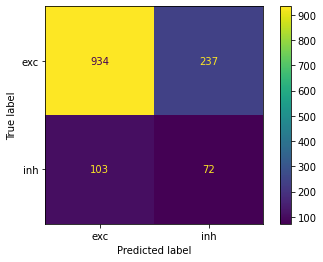

In [4]:
score = metrics.balanced_accuracy_score(y_test, best_y_pred)
recall = metrics.recall_score(y_test, best_y_pred)
precision = metrics.precision_score(y_test, best_y_pred)
f1 = metrics.f1_score(y_test, best_y_pred)

print('Balanced Acccuracy: \t{:.3f}'.format(score))
print('Recall: \t\t{:.3f}'.format(recall))
print('Precision: \t\t{:.3f}'.format(precision))
print('F1: \t\t\t{:.3f}'.format(f1))

cm = metrics.confusion_matrix(y_test, best_y_pred)
disp = metrics.ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['exc', 'inh'])
disp.plot()

In [5]:
with (open(file_path + 'params.pickle', "rb")) as openfile:
    while True:
        try:
            params = pickle.load(openfile)
        except EOFError:
                break

print(json.dumps(params, indent=4, sort_keys=False))

{
    "optimizer": "Adam",
    "lstm_hidden": 128,
    "lstm_layer": 1,
    "pooling_dim": 128,
    "lr": 0.0008,
    "dropout": 0.6,
    "weight_decay": 1.799623440960748e-05,
    "class_weights": [
        0.3,
        7.0
    ]
}


(49, 1725)
(1081, 1725)
(90, 1725)
(126, 1725)


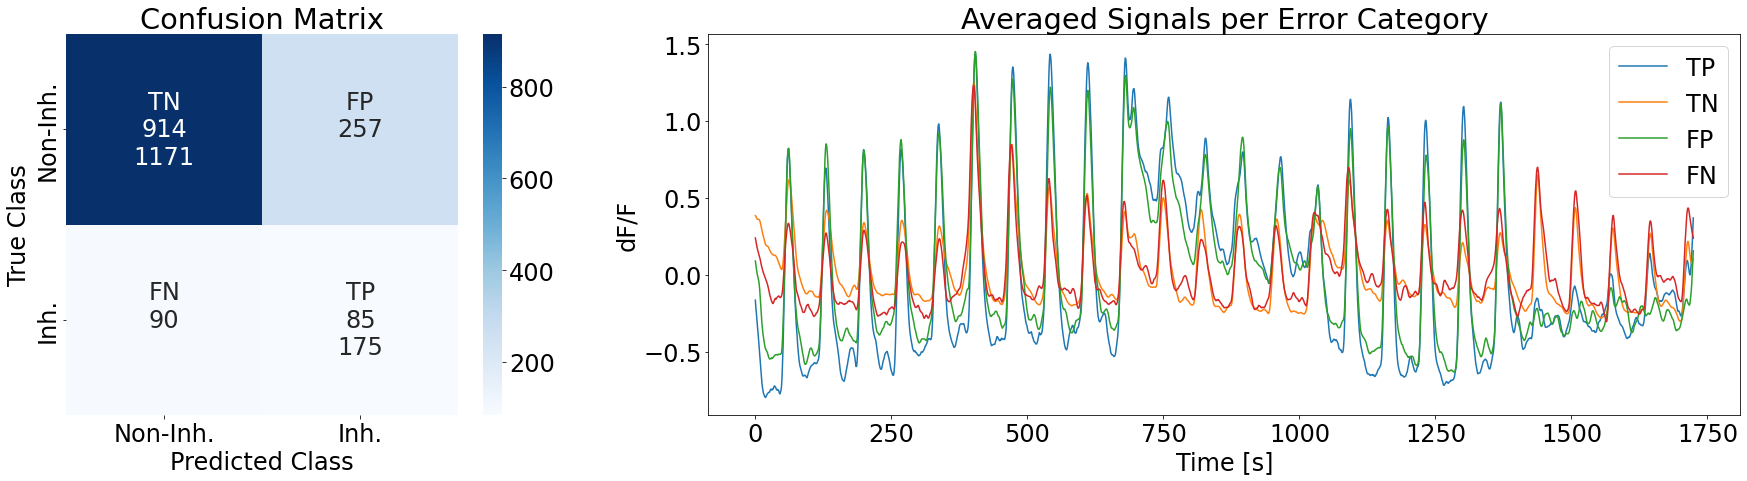

In [86]:
X_temp = np.load('../data/Haleh/X_test.npy')
y_test = np.load('../data/Haleh/y_test.npy')
thresh = 0.5
plotTP = X_temp[(best_y_proba[:, 1] >= thresh) * (y_test == 1)]
plotTN = X_temp[(best_y_proba[:, 1] <= (1-thresh)) * (y_test == 0)]
plotFP = X_temp[(best_y_proba[:, 1] >= thresh) * (y_test == 0)]
plotFN = X_temp[(best_y_proba[:, 1] <= (1-thresh)) * (y_test == 1)]
print(plotTP.shape)
print(plotTN.shape)
print(plotFP.shape)
print(plotFN.shape)
fig, ax = plt.subplots(1, 2, figsize=(30, 7), gridspec_kw={'width_ratios': [0.95, 2]})
plt.rcParams.update({'font.size': 24})

cm = metrics.confusion_matrix(y_test, best_y_pred)
group_names = ['TN', 'FP', 'FN', 'TP']
group_counts = ["{0:0.0f}".format(value) for value in
                cm.flatten()]
#gt_counts = [f'{int(y_test[y_test==0].shape[0])}', '', '', f'{int(y_test[y_test==1].shape[0])}']

group_percentages = ["{0:.2%}".format(value) for value in [plotTN/(plotTN+plotFP), plotFP/()]]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts, gt_counts)]
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm, annot=labels, fmt="", cmap='Blues', ax=ax[0])
ax[0].set_xticklabels(['Non-Inh.','Inh.'])
ax[0].set_yticklabels(['Non-Inh.','Inh.'])
ax[0].set_xlabel('Predicted Class')
ax[0].set_ylabel('True Class')
for tick in ax[0].get_yticklabels():
    tick.set_rotation(90)

ax[1].plot(np.mean(plotTP, axis=0).T, label='TP')
ax[1].plot(np.mean(plotTN, axis=0).T, label='TN')
ax[1].plot(np.mean(plotFP, axis=0).T, label='FP')
ax[1].plot(np.mean(plotFN, axis=0).T, label='FN')
ax[1].set_xlabel('Time [s]')
ax[1].set_ylabel('dF/F')

ax[0].set_title("Confusion Matrix")
ax[1].set_title("Averaged Signals per Error Category")
ax[1].legend()
#plt.savefig('Best_Prediction.png')

## Signals Statistics

In [7]:
X = np.load('../data/Haleh/X.npy')
y = np.load('../data/Haleh/y.npy')

In [8]:
np.unique(y, return_counts=True)

(array([0., 1.]), array([4683,  701]))

In [91]:
X_inh = X[y==1]
X_exc = X[y==0]

In [138]:
var_inh = np.var(X_inh, axis=1)
var_exc = np.var(X_exc, axis=1)

In [139]:
mean_var_inh = np.mean(var_inh)
mean_var_exc = np.mean(var_exc)
std_var_inh = np.std(var_inh)
std_var_exc = np.std(var_exc)
mean_inh = np.mean(X_inh, axis=0)
mean_exc = np.mean(X_exc, axis=0)
print(mean_inh.shape)
print(mean_exc.shape)

(1725,)
(1725,)


In [140]:
print(f'Averaged per signal variance (Inhibitory): {mean_var_inh:.2f} ± {std_var_inh:.2f}')
print(f'Averaged per signal variance (Excitatory): {mean_var_exc:.2f} ± {std_var_exc:.2f}')
print(f'Variance of averaged signal (Inhibitory):  {np.var(mean_inh):.2f}')
print(f'Variance of averaged signal (Excitatory):  {np.var(mean_exc):.2f}')

Averaged per signal variance (Inhibitory): 0.96 ± 0.16
Averaged per signal variance (Excitatory): 0.98 ± 0.15
Variance of averaged signal (Inhibitory):  0.10
Variance of averaged signal (Excitatory):  0.06


In [141]:
x_temp = np.arange(1725)

time_vector = np.reshape(x_temp, (x_temp.shape[0], 1))
signal_vector = np.reshape(X_inh[0], (X_inh.shape[1], 1))
data = np.concatenate((time_vector, signal_vector), axis=1)

for i in range(1, X_inh.shape[0]):
    signal_vector = np.reshape(X_inh[i], (X_inh.shape[1], 1))
    temp = np.concatenate((time_vector, signal_vector), axis=1)
    data = np.concatenate((data, temp), axis=0)
df_inh = pd.DataFrame(data=data, columns=['Time [s]', 'dF/F'])

In [142]:
df_inh.head()

,Time [s],dF/F
0,0.0,0.59327
1,1.0,0.40026
2,2.0,0.36132
3,3.0,0.31543
4,4.0,0.33022


In [143]:
x_temp = np.arange(1725)

time_vector = np.reshape(x_temp, (x_temp.shape[0], 1))
signal_vector = np.reshape(X_exc[0], (X_exc.shape[1], 1))
data = np.concatenate((time_vector, signal_vector), axis=1)

for i in range(X_exc.shape[0]):
    signal_vector = np.reshape(X_exc[i], (X_exc.shape[1], 1))
    temp = np.concatenate((time_vector, signal_vector), axis=1)
    data = np.concatenate((data, temp), axis=0)
    
df_exc = pd.DataFrame(data=data, columns=['Time [s]', 'dF/F'])

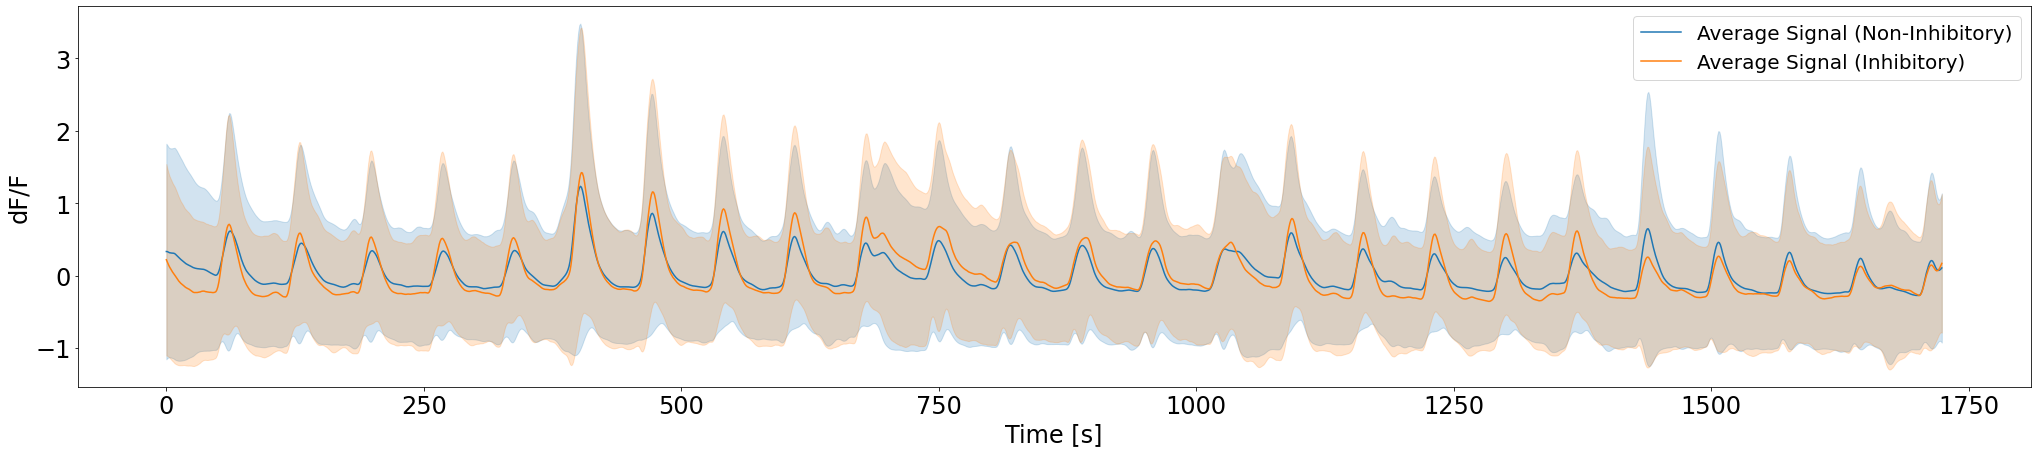

In [146]:
fig, ax = plt.subplots(figsize=(35, 7))
sns.lineplot(x="Time [s]", y="dF/F", data=df_exc, ax=ax, ci='sd', label='Average Signal (Non-Inhibitory)')
sns.lineplot(x="Time [s]", y="dF/F", data=df_inh, ax=ax, ci='sd', label='Average Signal (Inhibitory)')

plt.legend(fontsize=20)
plt.savefig('AverageSignals.png')

In [132]:
#plt.savefig('Average Signals')

<Figure size 432x288 with 0 Axes>